In [1]:
from griblib import HARMONIE
from griblib.io.ascii import write_profile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': 10.0, 'max': 30.0}
#temp_lim = {'min': -50.0, 'max': 0.0}
wind_lim = {'min': 10.0, 'max': 50.0}
z_lim = {'min': 0.0, 'max': 15.0, 'dz': 3.0}

# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
path_params['start'] = dict(lat=53.970, lon=5.806)
path_params['end'] = dict(lat=52.906795, lon=6.865549)
#path_params['type'] = 'range-azimuth'
#path_params['start'] = dict(lat=51.0, lon=0.0)
#path_params['range'] = 700.0e3
#path_params['azimuth'] = 60.0
dr = 1.0e3

In [5]:
import glob
#fid_grib = 'cy36/20190605_18/HARM_N25_201906051800_00000_GB'
#fid_grib = 'cy36/20190605_21/HARM_N25_201906052100_00000_GB'

#fid_grib = 'cy40/20190605_18/HA40_N25_201906051800_00200_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_00100_GB'
#fid_grib = 'cy40/20190605_21/HA40_N25_201906052100_01200_GB'
gribs = glob.glob('cy40/*/*_GB')
for fid_grib in sorted(gribs):
    print(fid_grib)

cy40/2021022615/HA40_N25_202102261500_00000_GB


In [6]:
my_atmos = HARMONIE(cycle='40')

In [7]:
request = [
    {'level_type': 'hybrid', 'var_list': ['z', 't', 'u', 'v', 'q', 'pdep', 'tke']},
    {'level_type': 'heightAboveGround', 'var_list': ['mld', 'ugst', 'vgst']},
    {'level_type': 'heightAboveGround', 'var_list': ['pres'], 'level': 0},
]

if my_atmos.cycle == 36:
    request.append({'level_type': 'hybrid', 'var_list': ['lsp', 'w']})
else:
    request.append({'level_type': 'hybrid', 'var_list': ['rain']})
    
ds = my_atmos.read_grib(fid_grib, request, compat='override')

ds_mslp = my_atmos.read_grib(fid_grib, [{'level_type': 'heightAboveSea'}])

ds = xr.merge([ds, ds_mslp.rename({'pres':'pres_msl'})])
del(ds_mslp)

********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/2021022615/HA40_N25_202102261500_00000_GB ]

Reading GRIB PV coefficients
Reading z on hybrid level
Reading t on hybrid level
Reading u on hybrid level
Reading v on hybrid level
Reading q on hybrid level
Reading pdep on hybrid level
Reading tke on hybrid level
Reading mld on heightAboveGround level
Reading ugst on heightAboveGround level
Reading vgst on heightAboveGround level
Reading pres on heightAboveGround level (level 0)
Reading rain on hybrid level
********************************************************************************
Reading HARMONIE cy40 GRIB file [ cy40/2021022615/HA40_N25_202102261500_00000_GB ]

Reading GRIB PV coefficients
Reading all variables on heightAboveSea level


In [8]:
# t_fcst = (ds.valid_time).dt.strftime('%Y%m%d-%H').values
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

(t_fcst, title_str, fid_prefix) = plot_prefix(my_atmos, ds)

In [9]:
ds_gcp = my_atmos.extract_gcp_slice(ds, path_params, dr=dr)

In [10]:
ds_gcp

<xarray.Dataset>
Dimensions:            (distance: 139, hybrid: 65)
Coordinates:
    time               datetime64[ns] 2021-02-26T15:00:00
    step               timedelta64[ns] 00:00:00
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65
    valid_time         datetime64[ns] 2021-02-26T15:00:00
    heightAboveGround  int64 0
    heightAboveSea     int64 0
    longitude          (distance) float64 5.806 5.814 5.822 ... 6.858 6.866
    latitude           (distance) float64 53.97 53.96 53.95 ... 52.91 52.91
  * distance           (distance) float64 0.0 997.8 ... 1.367e+05 1.377e+05
    azimuth            (distance) float64 148.8 148.8 148.8 ... 149.7 149.7
Data variables:
    z                  (hybrid, distance) float64 3.46e+05 3.46e+05 ... 255.7
    t                  (hybrid, distance) float64 209.2 209.2 ... 281.7 281.7
    u                  (hybrid, distance) float64 21.85 21.84 ... 3.424 3.412
    v                  (hybrid, distance) float64 1.4 1.4 ... -4.832 -4.846
    q                  (hybrid, distance) float64 4.324e-06 ... 0.004374
    pdep               (hybrid, distance) float64 0.001294 0.001554 ... 0.2709
    tke                (hybrid, distance) float64 0.001 0.001 ... 1.603 1.637
    mld                (distance) float64 195.7 200.7 ... 2.032e+03 2.039e+03
    ugst               (distance) float64 5.249 5.176 5.107 ... 6.572 6.575
    vgst               (distance) float64 -3.775 -3.621 -3.455 ... -7.623 -7.67
    pres               (distance) float64 1.034e+05 1.034e+05 ... 1.033e+05
    rain               (hybrid, distance) float64 -1e-38 -1e-38 ... -4.209e-22
    pres_msl           (distance) float64 1.034e+05 1.034e+05 ... 1.034e+05

In [11]:
# Temperature (in degrees Celcius)
temperature = ds_gcp['t'].squeeze() - 273.15
#temperature -= temperature.mean(dim='distance')
temperature.attrs= {'long_name': 'temperature',
                    'units' : 'deg C',
                    'standard_name': 'air_temperature'}

# Wind speed
windspeed = np.sqrt(ds_gcp.u**2+ds_gcp.v**2).squeeze()
#windspeed = windspeed.where(windspeed > 0.95*wind_lim['min'])
windspeed.attrs= {'long_name': 'wind speed',
                    'units' : 'm/s',
                    'standard_name': 'wind_speed'}

In [12]:
lons = ds_gcp.longitude.values
lats = ds_gcp.latitude.values
coord_str = '({slo:.1f}E,{sla:.1f}N) > ({elo:.1f}E,{ela:.1f}N)'.format(
    slo=lons[0], sla=lats[0], elo=lons[-1], ela=lats[-1])
title_str = '{model}{cycle} fcst {time} UT - gcp {coords}'.format(
    model=my_atmos.model, cycle=my_atmos.cycle, time=t_fcst, coords=coord_str)


fid_prefix = '{model}{cycle}_{time}'.format(model=my_atmos.model, 
                                            cycle=my_atmos.cycle, 
                                            time=t_fcst)

In [13]:
# compute pressure, geopotential and geometric altitudes on model levels

(z, pres) = my_atmos.compute_altitude_pressure(t=ds_gcp.t,
                                            q=ds_gcp.q,
                                            ps=ds_gcp.pres,
                                            z0=ds_gcp.z.sel(hybrid=len(ds.hybrid)))
dens = my_atmos.compute_density(pres, ds_gcp.t)

ds_gcp = ds_gcp.drop(['z', 'pres'])
ds_gcp = xr.merge([ds_gcp, z.to_dataset(), pres.to_dataset(), dens.to_dataset()])

In [14]:
(cT, wa, wc, ce) = my_atmos.infrasound_propagation_conditions(t=ds_gcp.t,
                                                              u=ds_gcp.u,
                                                              v=ds_gcp.v,
                                                              azimuth=ds_gcp.azimuth)

c0 = ce.sel(hybrid=len(ds.hybrid))
cr = my_atmos.effective_sound_speed_ratio(ce, c0)

ds_gcp = xr.merge([cT.to_dataset(),
                   wa.to_dataset(),
                   wc.to_dataset(),
                   ce.to_dataset(),
                   cr.to_dataset(),
                   ds_gcp],
                   compat='override')

In [15]:
ds_gcp

<xarray.Dataset>
Dimensions:            (distance: 139, hybrid: 65)
Coordinates:
    time               datetime64[ns] 2021-02-26T15:00:00
    step               timedelta64[ns] 00:00:00
  * hybrid             (hybrid) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65
    valid_time         datetime64[ns] 2021-02-26T15:00:00
    heightAboveGround  int64 0
    heightAboveSea     int64 0
    longitude          (distance) float64 5.806 5.814 5.822 ... 6.858 6.866
    latitude           (distance) float64 53.97 53.96 53.95 ... 52.91 52.91
  * distance           (distance) float64 0.0 997.8 ... 1.367e+05 1.377e+05
    azimuth            (distance) float64 148.8 148.8 148.8 ... 149.7 149.7
Data variables:
    cT                 (hybrid, distance) float64 289.9 289.9 ... 336.5 336.5
    wa                 (hybrid, distance) float64 10.12 10.11 ... 5.899 5.905
    wc                 (hybrid, distance) float64 19.42 19.41 ... 0.5139 0.4975
    ce                 (hybrid, distance) float64 300.0 300.0 ... 342.4 342.4
    cr                 (hybrid, distance) float64 0.8832 0.8835 ... 1.0 1.0
    t                  (hybrid, distance) float64 209.2 209.2 ... 281.7 281.7
    u                  (hybrid, distance) float64 21.85 21.84 ... 3.424 3.412
    v                  (hybrid, distance) float64 1.4 1.4 ... -4.832 -4.846
    q                  (hybrid, distance) float64 4.324e-06 ... 0.004374
    pdep               (hybrid, distance) float64 0.001294 0.001554 ... 0.2709
    tke                (hybrid, distance) float64 0.001 0.001 ... 1.603 1.637
    mld                (distance) float64 195.7 200.7 ... 2.032e+03 2.039e+03
    ugst               (distance) float64 5.249 5.176 5.107 ... 6.572 6.575
    vgst               (distance) float64 -3.775 -3.621 -3.455 ... -7.623 -7.67
    rain               (hybrid, distance) float64 -1e-38 -1e-38 ... -4.209e-22
    pres_msl           (distance) float64 1.034e+05 1.034e+05 ... 1.034e+05
    z                  (hybrid, distance) float64 3.05e+04 3.05e+04 ... 38.33
    pres               (hybrid, distance) float64 1e+03 1e+03 ... 1.031e+05
    den                (hybrid, distance) float64 0.01666 0.01665 ... 1.275

In [16]:
nlev = ds_gcp.dims['hybrid']
nrng = ds_gcp.dims['distance']

x = np.broadcast_to(np.expand_dims(ds_gcp.distance, axis=0), shape=(nlev, nrng)) / 1e3
y = ds_gcp.z / 1e3

print(x.shape, y.shape)

(65, 139) (65, 139)


In [17]:
def plot_infrasound_profile(self, ds, layer):
    (t_fcst, model_str, fid_prefix) = plot_prefix(self, ds)
    
    n_plots = 3

    z_lim = {'min': layer['z_min'], 'max': layer['z_max']}
    z_ticks = np.arange(z_lim['min'], z_lim['max'], layer['dz'])
    elevation = y.sel(hybrid=len(ds.hybrid)).data

    # plot it
    fig, ax = plt.subplots(n_plots, 2, sharey=True, figsize=(9,6), gridspec_kw={'width_ratios': [1, 5]})
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.075, hspace=0.5)

    ax[0,0].plot(ds_gcp['cT'], y.mean(axis=1), color='gray')
    ax[0,0].plot(ds_gcp['cT'].mean(axis=1), y.mean(axis=1), color='red')
    ax[0,0].set_xlabel('$c_T$ [m/s]')
    im = ax[0,1].pcolormesh(x, y, ds_gcp['cT'],
                            cmap='Spectral_r',
                            vmin=320, vmax=340)
    ax[0,1].contour(x, y, ds_gcp['cT'], 
                    colors='black', levels=np.arange(300., 340, 5.), alpha=0.1)
    plt.colorbar(im,ax=ax[0,1],label='$c_T$ [m/s]')

    ax[1,0].plot(ds_gcp['wa'], y.mean(axis=1), color='gray')
    ax[1,0].plot(ds_gcp['wa'].mean(axis=1), y.mean(axis=1), color='red')
    ax[1,0].set_xlabel('$w_{a}$ [m/s]')
    im = ax[1,1].pcolormesh(x, y, ds_gcp['wa'],
                            cmap='Spectral_r',
                            vmin=10, vmax=30)
    plt.colorbar(im,ax=ax[1,1],label='$w_{a}$ [m/s]')
    ax[1,1].contour(x, y, ds_gcp['wa'], 
                    colors='black', levels=np.arange(-20, 20, 5.), alpha=0.1)

    ax[2,0].plot(ds_gcp['cr'], y.mean(axis=1), color='gray')
    ax[2,0].plot(ds_gcp['cr'].mean(axis=1), y.mean(axis=1), color='red')
    ax[2,0].set_xlim([0.97, 1.03 ])

    xx = ds_gcp['cr'].where(ds_gcp['cr'] > 0.99)
    im = ax[2,1].pcolormesh(x, y, xx,
                            cmap='inferno_r',
                            vmin=0.99, vmax=1.05)
    ax[2,1].contour(x, y, ds_gcp['cr'],
                    colors='black', levels=np.arange(0.99, 1.05, 0.01), alpha=0.1)
    plt.colorbar(im,ax=ax[2,1],label='c$_{e}$ ratio [-]')
    ax[2,0].set_xlabel('c$_{e} ratio$ [-]')

    for i in range(0,n_plots):
        ax[i,0].set_ylabel('Altitude [km]')
        ax[i,1].fill_between(x[0], 0, elevation, facecolor='gray', alpha=0.9)
        for j in range(0,2):
            ax[i,j].set_ylim(z_lim['min'], z_lim['max'])
            ax[i,j].set_yticks(z_ticks)

    ax[2,1].set_xlabel('Range [km]')
    #ax[0,1].set_title(title_str)

    fig.suptitle(title_str)
    fig.tight_layout()

    fid_gcp = '{}_{}_profile.png'.format(fid_prefix, layer['fid'])
    fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

    plt.show()

<ipython-input-17-a7ad867c253c>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0,1].pcolormesh(x, y, ds_gcp['cT'],
<ipython-input-17-a7ad867c253c>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1,1].pcolormesh(x, y, ds_gcp['wa'],
<ipython-input-17-a7ad867c253c>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and 

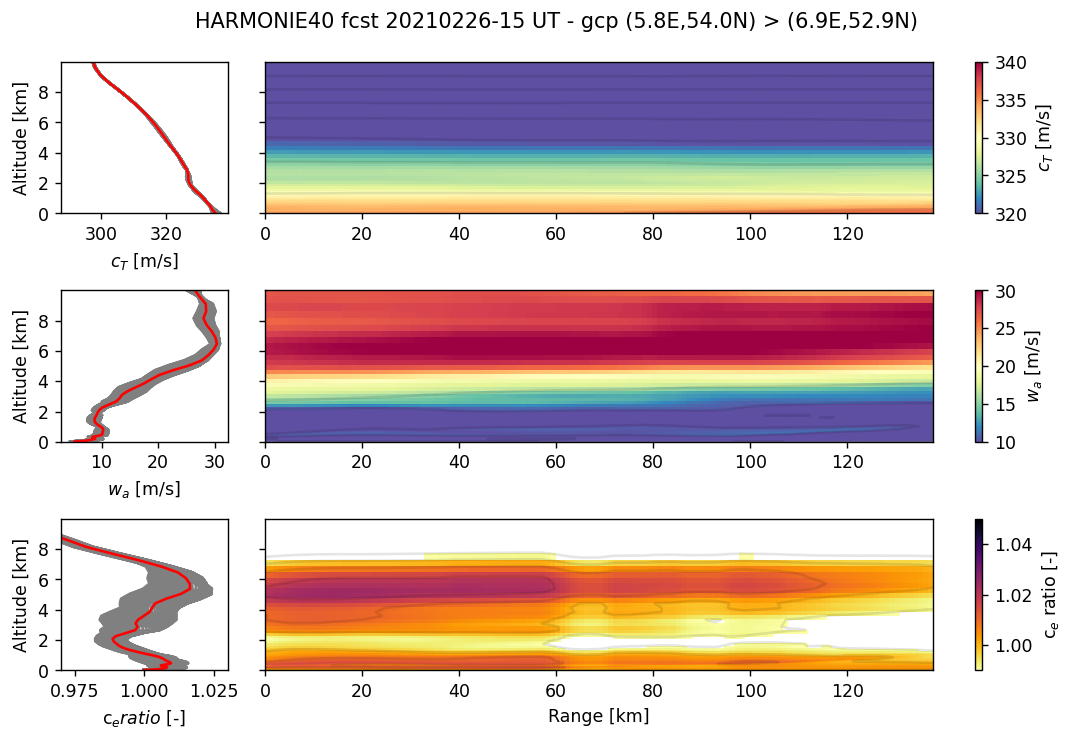

In [18]:
layers = dict()
layers['surface'] = dict(fid='surface', description='Near surface (0-6 km)',
                         z_min=0.0, z_max=10.0, dz=2.0)
# layers['strato'] = dict(fid='strato', description='Troposphere - Stratosphere (0-60 km)',
#                         z_min=0.0, z_max=60.0, dz=10)

for item in layers.keys():
    plot_infrasound_profile(my_atmos, ds, layers[item])